# ML Notebook (Submission-ready)
Unsupervised learning: KMeans clustering + PCA visualisation.

This notebook loads the cleaned outputs and reproduces clustering:
1) All firms (10) and
2) Sensitivity analysis excluding the outlier (TNDT).

Exports tables and figures to `outputs/`.

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
from IPython.display import display

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

BASE_DIR = Path("D:/UWE CLASS/CSCT master/Project")
OUT_DIR = BASE_DIR / "outputs"
FIG_DIR = OUT_DIR / "figures"
OUT_DIR.mkdir(exist_ok=True)
FIG_DIR.mkdir(exist_ok=True)

def std_ticker(s: pd.Series) -> pd.Series:
    return s.astype(str).str.strip().str.upper()


## 1) Load cleaned data and build firm-level dataset (10 firms)

In [2]:
fin = pd.read_excel(OUT_DIR / "financial_clean.xlsx").copy()
cmp = pd.read_excel(OUT_DIR / "company_analysis.xlsx").copy()

fin["Ticker"] = std_ticker(fin["Ticker"])
cmp["Ticker"] = std_ticker(cmp["Ticker"])
fin["Year"] = fin["Year"].astype(int)

# main years only (2022–2023)
fin_main = fin[fin["Use in main analysis? (Y/N)"].astype(str).str.upper().eq("Y")].copy()
fin_main["log_assets"] = np.log(fin_main["Total Assets (THB mn) [Input]"])

merged = fin_main.merge(
    cmp[["Ticker","Sustainability Disclosure Group","Industry Sector","Listing Age (Years)"]],
    on="Ticker",
    how="left"
)

features = ["ROA [Formula]","ROE [Formula]","Net Profit Margin [Formula]","D/E [Formula]","log_assets"]

firm = (
    merged.groupby(["Ticker","Sustainability Disclosure Group"], as_index=False)[features]
    .mean()
    .rename(columns={"Sustainability Disclosure Group":"SR_group"})
)
firm["SR"] = firm["SR_group"].astype(int)

print("Firm-level shape:", firm.shape)
print("SR counts:", firm["SR"].value_counts().to_dict())
display(firm)


Firm-level shape: (10, 8)
SR counts: {1: 5, 0: 5}


,Ticker,SR_group,ROA [Formula],ROE [Formula],Net Profit Margin [Formula],D/E [Formula],log_assets,SR
0,AKP,1,0.031894,0.038103,0.060760,0.190689,6.582052,1
1,APO,0,0.060802,0.090506,0.010985,0.464064,5.819799,0
2,BSM,1,-0.032926,-0.098377,-0.074750,1.971694,7.162894,1
3,CIG,0,-0.076398,-0.542003,-0.054606,3.230410,6.903218,0
4,DOD,0,-0.151815,-0.221102,-0.357960,0.402364,7.223842,0
5,MPJ,0,0.101878,0.294290,0.078012,1.939377,6.772543,0
6,PPS,1,0.002094,0.005097,0.005113,1.007378,6.471653,1
7,PROEN,1,0.024883,0.083357,0.031327,2.300637,7.433949,1
8,TMILL,1,0.043203,0.078249,0.043603,0.779538,7.550930,1
9,TNDT,0,-0.280225,-1.539656,-0.692842,3.182142,6.808693,0


## 2) Clustering (all firms): choose k with silhouette

In [3]:
X = firm[features].replace([np.inf, -np.inf], np.nan).dropna()
firm_all = firm.loc[X.index].copy()

scaler = StandardScaler()
Xz = scaler.fit_transform(X)

scores=[]
for k in [2,3,4]:
    labels = KMeans(n_clusters=k, n_init=50, random_state=42).fit_predict(Xz)
    score = silhouette_score(Xz, labels)
    scores.append((k,score))
    print(f"k={k}, silhouette={score:.3f}")

best_k = max(scores, key=lambda t: t[1])[0]
print("Best k:", best_k)


k=2, silhouette=0.480
k=3, silhouette=0.254
k=4, silhouette=0.263
Best k: 2


## 3) Fit KMeans + cluster profiling (all firms)

In [4]:
k_best = best_k  # usually 2 for this dataset size
km = KMeans(n_clusters=k_best, n_init=50, random_state=42)
firm_all["cluster"] = km.fit_predict(Xz)

display(firm_all[["Ticker","SR","cluster"]].sort_values(["cluster","SR","Ticker"]))

profile_all = firm_all.groupby("cluster")[features].mean()
ct_all = pd.crosstab(firm_all["cluster"], firm_all["SR"])
ct_all_pct = ct_all.div(ct_all.sum(axis=1), axis=0)

display(profile_all)
display(ct_all)
display(ct_all_pct)

firm_all.to_excel(OUT_DIR / "ml_kmeans_all_firms_clusters.xlsx", index=False)
profile_all.to_excel(OUT_DIR / "ml_kmeans_all_firms_profile.xlsx")
ct_all.to_excel(OUT_DIR / "ml_kmeans_all_firms_cluster_vs_SR_counts.xlsx")
ct_all_pct.to_excel(OUT_DIR / "ml_kmeans_all_firms_cluster_vs_SR_rowpct.xlsx")

print("Saved all-firms clustering tables to outputs/")


,Ticker,SR,cluster
1,APO,0,0
3,CIG,0,0
4,DOD,0,0
5,MPJ,0,0
0,AKP,1,0
2,BSM,1,0
6,PPS,1,0
7,PROEN,1,0
8,TMILL,1,0
9,TNDT,0,1


,ROA [Formula],ROE [Formula],Net Profit Margin [Formula],D/E [Formula],log_assets
cluster,,,,,
0,0.000402,-0.030209,-0.028613,1.365128,6.880098
1,-0.280225,-1.539656,-0.692842,3.182142,6.808693


SR,0,1
cluster,,
0,4,5
1,1,0


SR,0,1
cluster,,
0,0.444444,0.555556
1,1.000000,0.000000


Saved all-firms clustering tables to outputs/


## 4) PCA plots (all firms)

Explained variance ratio: [0.6368374  0.21205302]


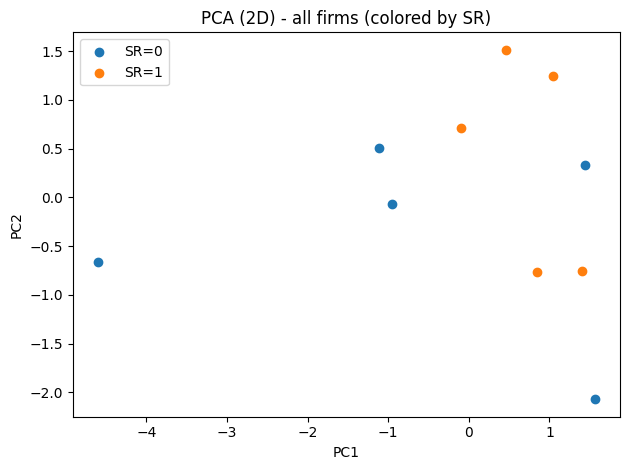

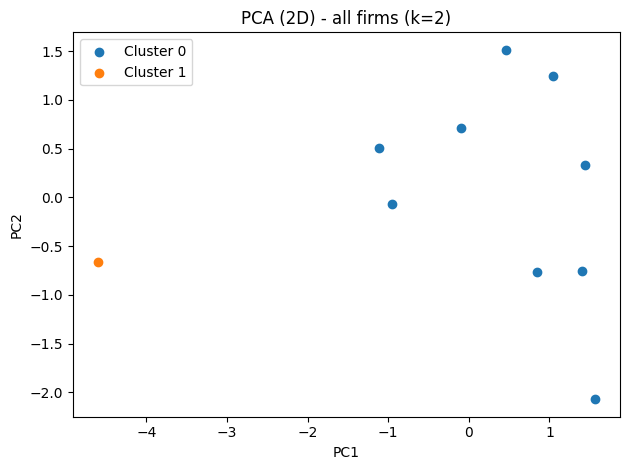

Saved PCA figures to: D:\UWE CLASS\CSCT master\Project\outputs\figures


In [5]:
pca = PCA(n_components=2, random_state=42)
Z = pca.fit_transform(Xz)
print("Explained variance ratio:", pca.explained_variance_ratio_)

# PCA by SR
plt.figure()
for sr in [0,1]:
    m = (firm_all["SR"].values == sr)
    plt.scatter(Z[m,0], Z[m,1], label=f"SR={sr}")
plt.title("PCA (2D) - all firms (colored by SR)")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.legend()
plt.tight_layout()
plt.savefig(FIG_DIR / "pca_all_firms_by_SR.png", dpi=300, bbox_inches="tight")
plt.show()

# PCA by cluster
plt.figure()
for c in sorted(firm_all["cluster"].unique()):
    m = (firm_all["cluster"].values == c)
    plt.scatter(Z[m,0], Z[m,1], label=f"Cluster {c}")
plt.title(f"PCA (2D) - all firms (k={k_best})")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.legend()
plt.tight_layout()
plt.savefig(FIG_DIR / "pca_all_firms_by_cluster.png", dpi=300, bbox_inches="tight")
plt.show()

print("Saved PCA figures to:", FIG_DIR)


## 5) Sensitivity analysis: exclude outlier TNDT

In [6]:
firm_no = firm_all[firm_all["Ticker"] != "TNDT"].copy()
X_no = firm_no[features].replace([np.inf, -np.inf], np.nan).dropna()
firm_no = firm_no.loc[X_no.index].copy()

Xz_no = StandardScaler().fit_transform(X_no)

scores=[]
for k in [2,3,4]:
    labels = KMeans(n_clusters=k, n_init=50, random_state=42).fit_predict(Xz_no)
    score = silhouette_score(Xz_no, labels)
    scores.append((k,score))
    print(f"k={k}, silhouette={score:.3f}")

best_k_no = max(scores, key=lambda t: t[1])[0]
print("Best k (no TNDT):", best_k_no)


k=2, silhouette=0.296
k=3, silhouette=0.225
k=4, silhouette=0.231
Best k (no TNDT): 2


## 6) Fit KMeans + profiling (no TNDT)

In [7]:
k_best_no = best_k_no
km_no = KMeans(n_clusters=k_best_no, n_init=50, random_state=42)
firm_no["cluster"] = km_no.fit_predict(Xz_no)

display(firm_no[["Ticker","SR","cluster"]].sort_values(["cluster","SR","Ticker"]))

profile_no = firm_no.groupby("cluster")[features].mean()
ct_no = pd.crosstab(firm_no["cluster"], firm_no["SR"])
ct_no_pct = ct_no.div(ct_no.sum(axis=1), axis=0)

display(profile_no)
display(ct_no)
display(ct_no_pct)

firm_no.to_excel(OUT_DIR / "ml_kmeans_no_TNDT_clusters.xlsx", index=False)
profile_no.to_excel(OUT_DIR / "ml_kmeans_no_TNDT_profile.xlsx")
ct_no.to_excel(OUT_DIR / "ml_kmeans_no_TNDT_cluster_vs_SR_counts.xlsx")
ct_no_pct.to_excel(OUT_DIR / "ml_kmeans_no_TNDT_cluster_vs_SR_rowpct.xlsx")

print("Saved no-TNDT clustering tables to outputs/")


,Ticker,SR,cluster
3,CIG,0,0
4,DOD,0,0
2,BSM,1,0
1,APO,0,1
5,MPJ,0,1
0,AKP,1,1
6,PPS,1,1
7,PROEN,1,1
8,TMILL,1,1


,ROA [Formula],ROE [Formula],Net Profit Margin [Formula],D/E [Formula],log_assets
cluster,,,,,
0,-0.087046,-0.287160,-0.162439,1.868156,7.096651
1,0.044126,0.098267,0.038300,1.113614,6.771821


SR,0,1
cluster,,
0,2,1
1,2,4


SR,0,1
cluster,,
0,0.666667,0.333333
1,0.333333,0.666667


Saved no-TNDT clustering tables to outputs/


## 7) PCA plots (no TNDT)

Explained variance ratio: [0.53499745 0.25534745]


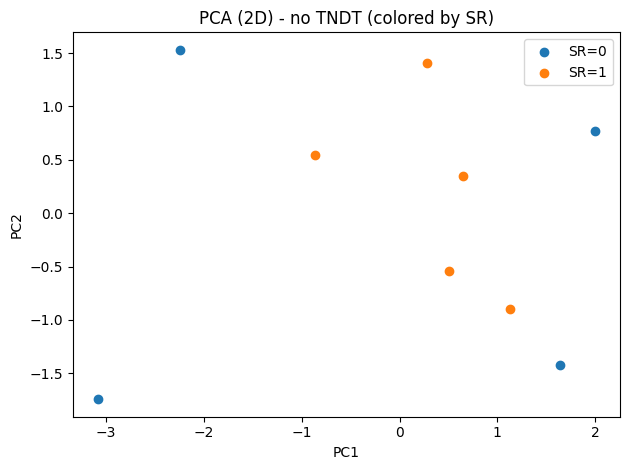

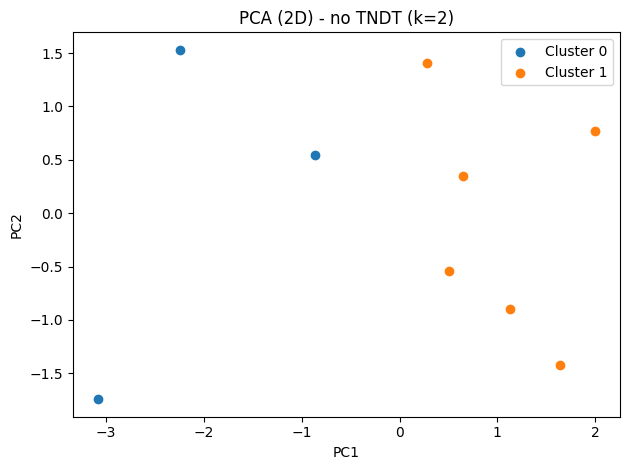

Saved PCA figures to: D:\UWE CLASS\CSCT master\Project\outputs\figures


In [8]:
pca = PCA(n_components=2, random_state=42)
Z_no = pca.fit_transform(Xz_no)
print("Explained variance ratio:", pca.explained_variance_ratio_)

plt.figure()
for sr in [0,1]:
    m = (firm_no["SR"].values == sr)
    plt.scatter(Z_no[m,0], Z_no[m,1], label=f"SR={sr}")
plt.title("PCA (2D) - no TNDT (colored by SR)")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.legend()
plt.tight_layout()
plt.savefig(FIG_DIR / "pca_no_TNDT_by_SR.png", dpi=300, bbox_inches="tight")
plt.show()

plt.figure()
for c in sorted(firm_no["cluster"].unique()):
    m = (firm_no["cluster"].values == c)
    plt.scatter(Z_no[m,0], Z_no[m,1], label=f"Cluster {c}")
plt.title(f"PCA (2D) - no TNDT (k={k_best_no})")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.legend()
plt.tight_layout()
plt.savefig(FIG_DIR / "pca_no_TNDT_by_cluster.png", dpi=300, bbox_inches="tight")
plt.show()

print("Saved PCA figures to:", FIG_DIR)


## Supervised ML: Baseline vs Logistic Regression vs (Optional) Random Forest

**Goal:** predict whether a firm is in SR group (SR=1) using firm-level financial ratios (averaged over 2022–2023).

> Note: N is very small (~10 firms), so results are **exploratory** only (high variance, not for strong claims).


In [9]:
import numpy as np
import pandas as pd

from sklearn.model_selection import LeaveOneOut
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

# Firm-level dataset already created earlier as: firm
df_ml = firm.copy()
y = df_ml["SR"].astype(int).values

loo = LeaveOneOut()

def eval_dummy(strategy, constant=None):
    if strategy == "constant":
        clf = DummyClassifier(strategy=strategy, constant=constant)
        name = f"Dummy_{strategy}_{constant}"
    else:
        clf = DummyClassifier(strategy=strategy)
        name = f"Dummy_{strategy}"

    y_true, y_pred = [], []

    for train_idx, test_idx in loo.split(y):
        # sklearn requires X; use dummy zeros
        X_train = np.zeros((len(train_idx), 1))
        X_test  = np.zeros((1, 1))

        clf.fit(X_train, y[train_idx])
        pred = clf.predict(X_test)[0]

        y_true.append(int(y[test_idx][0]))
        y_pred.append(int(pred))

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    acc = accuracy_score(y_true, y_pred)
    f1  = f1_score(y_true, y_pred, zero_division=0)
    cm  = confusion_matrix(y_true, y_pred)

    print(f"\n=== Baseline ({name}) - LOOCV ===")
    print("N:", len(y_true))
    print("Accuracy:", round(acc, 3))
    print("F1-score:", round(f1, 3))
    print("\nConfusion Matrix:\n", cm)
    print("\nClassification Report:\n", classification_report(y_true, y_pred, digits=3, zero_division=0))

    return {"model": name, "N": len(y_true), "accuracy": acc, "f1": f1}

# For balanced 5/5 data, most_frequent can give 0% in LOOCV (majority flips each fold).
m1 = eval_dummy("constant", constant=0)
m2 = eval_dummy("constant", constant=1)
m3 = eval_dummy("most_frequent")

baseline_metrics = pd.DataFrame([m1, m2, m3])
display(baseline_metrics)



=== Baseline (Dummy_constant_0) - LOOCV ===
N: 10
Accuracy: 0.5
F1-score: 0.0

Confusion Matrix:
 [[5 0]
 [5 0]]

Classification Report:
               precision    recall  f1-score   support

           0      0.500     1.000     0.667         5
           1      0.000     0.000     0.000         5

    accuracy                          0.500        10
   macro avg      0.250     0.500     0.333        10
weighted avg      0.250     0.500     0.333        10


=== Baseline (Dummy_constant_1) - LOOCV ===
N: 10
Accuracy: 0.5
F1-score: 0.667

Confusion Matrix:
 [[0 5]
 [0 5]]

Classification Report:
               precision    recall  f1-score   support

           0      0.000     0.000     0.000         5
           1      0.500     1.000     0.667         5

    accuracy                          0.500        10
   macro avg      0.250     0.500     0.333        10
weighted avg      0.250     0.500     0.333        10


=== Baseline (Dummy_most_frequent) - LOOCV ===
N: 10
Accuracy: 0.

,model,N,accuracy,f1
0,Dummy_constant_0,10,0.5,0.000000
1,Dummy_constant_1,10,0.5,0.666667
2,Dummy_most_frequent,10,0.0,0.000000


In [10]:
import numpy as np
import pandas as pd

from sklearn.model_selection import LeaveOneOut
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, f1_score, confusion_matrix, classification_report,
    roc_auc_score
)

# Firm-level dataset already created earlier as: firm
df_ml = firm.copy()

# Target
y = df_ml["SR"].astype(int)

# Features
features = [
    "ROA [Formula]",
    "ROE [Formula]",
    "Net Profit Margin [Formula]",
    "D/E [Formula]",
    "log_assets"
]
X = df_ml[features].copy()

print("Rows:", len(df_ml), "| SR counts:", y.value_counts().to_dict())
print("Missing in features:", X.isna().sum().to_dict())

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(penalty="l2", solver="liblinear", random_state=42))
])

loo = LeaveOneOut()
y_true, y_pred, y_prob = [], [], []

for train_idx, test_idx in loo.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    pipe.fit(X_train, y_train)
    pred = pipe.predict(X_test)[0]
    prob = pipe.predict_proba(X_test)[0, 1]

    y_true.append(int(y_test.values[0]))
    y_pred.append(int(pred))
    y_prob.append(float(prob))

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_prob = np.array(y_prob)

acc = accuracy_score(y_true, y_pred)
f1  = f1_score(y_true, y_pred, zero_division=0)

try:
    auc = roc_auc_score(y_true, y_prob)
except Exception:
    auc = np.nan

cm = confusion_matrix(y_true, y_pred)

print("\n=== Logistic Regression (L2) - LOOCV ===")
print("Accuracy:", round(acc, 3))
print("F1-score:", round(f1, 3))
print("ROC-AUC:", round(auc, 3) if not np.isnan(auc) else "NA")
print("\nConfusion Matrix:\n", cm)
print("\nClassification Report:\n", classification_report(y_true, y_pred, digits=3, zero_division=0))

# Fit on full data for coefficient interpretation (exploratory)
pipe.fit(X, y)
clf = pipe.named_steps["clf"]
coef = clf.coef_[0]

coef_table = pd.DataFrame({
    "feature": features,
    "coef": coef,
    "odds_ratio": np.exp(coef)
}).sort_values("odds_ratio", ascending=False)

display(coef_table)

# Save
from pathlib import Path
BASE_DIR = Path("D:/UWE CLASS/CSCT master/Project")
OUT_DIR = BASE_DIR / "outputs"
OUT_DIR.mkdir(exist_ok=True)

pred_table = df_ml[["Ticker","SR"]].copy() if "Ticker" in df_ml.columns else pd.DataFrame({"SR": y})
pred_table["y_true"] = y_true
pred_table["y_pred"] = y_pred
pred_table["p_SR1"]  = y_prob

metrics_table = pd.DataFrame([{
    "model": "LogisticRegression_L2_LOOCV_firm_level",
    "N": len(df_ml),
    "accuracy": acc,
    "f1": f1,
    "roc_auc": auc
}])

with pd.ExcelWriter(OUT_DIR / "ml_logistic_firm_loocv.xlsx", engine="openpyxl") as writer:
    metrics_table.to_excel(writer, sheet_name="metrics", index=False)
    pd.DataFrame(cm, index=["true_0","true_1"], columns=["pred_0","pred_1"]).to_excel(writer, sheet_name="confusion_matrix")
    pred_table.to_excel(writer, sheet_name="predictions", index=False)
    coef_table.to_excel(writer, sheet_name="coefficients", index=False)

print("Saved:", OUT_DIR / "ml_logistic_firm_loocv.xlsx")


Rows: 10 | SR counts: {1: 5, 0: 5}
Missing in features: {'ROA [Formula]': 0, 'ROE [Formula]': 0, 'Net Profit Margin [Formula]': 0, 'D/E [Formula]': 0, 'log_assets': 0}

=== Logistic Regression (L2) - LOOCV ===
Accuracy: 0.4
F1-score: 0.5
ROC-AUC: 0.4

Confusion Matrix:
 [[1 4]
 [2 3]]

Classification Report:
               precision    recall  f1-score   support

           0      0.333     0.200     0.250         5
           1      0.429     0.600     0.500         5

    accuracy                          0.400        10
   macro avg      0.381     0.400     0.375        10
weighted avg      0.381     0.400     0.375        10



,feature,coef,odds_ratio
4,log_assets,0.687322,1.988383
2,Net Profit Margin [Formula],0.634658,1.886376
0,ROA [Formula],0.227856,1.255905
1,ROE [Formula],0.189394,1.208517
3,D/E [Formula],-0.380390,0.683595


Saved: D:\UWE CLASS\CSCT master\Project\outputs\ml_logistic_firm_loocv.xlsx


### Optional: Random Forest (non-linear baseline)


In [11]:
import numpy as np
import pandas as pd

from sklearn.model_selection import LeaveOneOut
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, roc_auc_score

# Firm-level dataset already created earlier as: firm
df_ml = firm.copy()
y = df_ml["SR"].astype(int).values

features = [
    "ROA [Formula]",
    "ROE [Formula]",
    "Net Profit Margin [Formula]",
    "D/E [Formula]",
    "log_assets"
]
X = df_ml[features].copy().values

loo = LeaveOneOut()

y_true, y_pred, y_prob = [], [], []

# Keep RF small to reduce overfitting risk on tiny N
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=3,
    min_samples_leaf=2,
    random_state=42
)

for train_idx, test_idx in loo.split(X):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    rf.fit(X_train, y_train)
    pred = rf.predict(X_test)[0]
    prob = rf.predict_proba(X_test)[0, 1]

    y_true.append(int(y_test[0]))
    y_pred.append(int(pred))
    y_prob.append(float(prob))

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_prob = np.array(y_prob)

acc = accuracy_score(y_true, y_pred)
f1  = f1_score(y_true, y_pred, zero_division=0)
cm  = confusion_matrix(y_true, y_pred)

try:
    auc = roc_auc_score(y_true, y_prob)
except Exception:
    auc = np.nan

print("\n=== Random Forest (small) - LOOCV ===")
print("Accuracy:", round(acc, 3))
print("F1-score:", round(f1, 3))
print("ROC-AUC:", round(auc, 3) if not np.isnan(auc) else "NA")
print("\nConfusion Matrix:\n", cm)
print("\nClassification Report:\n", classification_report(y_true, y_pred, digits=3, zero_division=0))

# Feature importance (fit on full data for a simple view)
rf.fit(X, y)
imp = pd.DataFrame({"feature": features, "importance": rf.feature_importances_}).sort_values("importance", ascending=False)
display(imp)

# Save
from pathlib import Path
BASE_DIR = Path("D:/UWE CLASS/CSCT master/Project")
OUT_DIR = BASE_DIR / "outputs"
OUT_DIR.mkdir(exist_ok=True)

metrics_table = pd.DataFrame([{
    "model": "RandomForest_small_LOOCV_firm_level",
    "N": len(df_ml),
    "accuracy": acc,
    "f1": f1,
    "roc_auc": auc
}])

with pd.ExcelWriter(OUT_DIR / "ml_random_forest_firm_loocv.xlsx", engine="openpyxl") as writer:
    metrics_table.to_excel(writer, sheet_name="metrics", index=False)
    pd.DataFrame(cm, index=["true_0","true_1"], columns=["pred_0","pred_1"]).to_excel(writer, sheet_name="confusion_matrix")
    imp.to_excel(writer, sheet_name="feature_importance", index=False)

print("Saved:", OUT_DIR / "ml_random_forest_firm_loocv.xlsx")



=== Random Forest (small) - LOOCV ===
Accuracy: 0.5
F1-score: 0.615
ROC-AUC: 0.44

Confusion Matrix:
 [[1 4]
 [1 4]]

Classification Report:
               precision    recall  f1-score   support

           0      0.500     0.200     0.286         5
           1      0.500     0.800     0.615         5

    accuracy                          0.500        10
   macro avg      0.500     0.500     0.451        10
weighted avg      0.500     0.500     0.451        10



,feature,importance
1,ROE [Formula],0.271878
0,ROA [Formula],0.254495
2,Net Profit Margin [Formula],0.178034
4,log_assets,0.166426
3,D/E [Formula],0.129167


Saved: D:\UWE CLASS\CSCT master\Project\outputs\ml_random_forest_firm_loocv.xlsx
